In [118]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [160]:
data = pd.read_csv("./application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("./credit_record.csv", encoding = 'utf-8')  

In [161]:
df_null = data.isna().sum()
df_null_values = df_null[df_null>0]
df_null_values.sort_values(ascending=False)

OCCUPATION_TYPE    134203
dtype: int64

In [162]:
data.drop(["OCCUPATION_TYPE"],axis =1,inplace=True)

In [164]:
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0


In [123]:
#examining the duplicate IDs, sorting by ID
duplicated_ids = record[record['ID'].duplicated(keep='first')]['ID'].values
record[record['ID'].isin(duplicated_ids)].sort_values(by=['ID',"MONTHS_BALANCE"]).head(10)

,ID,MONTHS_BALANCE,STATUS
3,5001711,-3,0
2,5001711,-2,0
1,5001711,-1,0
0,5001711,0,X
22,5001712,-18,0
21,5001712,-17,0
20,5001712,-16,0
19,5001712,-15,0
18,5001712,-14,0
17,5001712,-13,0


In [165]:
### why are we doing this?
data[data['DAYS_BIRTH']==-15272].head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
97417,5403669,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15272,-5604,1,0,1,0,2.0
97418,5403674,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15272,-5604,1,0,1,0,2.0
97419,5403675,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15272,-5604,1,0,1,0,2.0
97420,6154303,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15272,-5604,1,0,1,0,2.0
106692,5452063,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,-15272,-2012,1,1,1,0,3.0


In [166]:
print("unique ID's: ",len(data["ID"].unique()))
print("total number rows: ", data.shape[0])
print("Difference: ", data.shape[0]- len(data["ID"].unique()))
print("Number of duplicated rows: ",sum(data.duplicated()))

unique ID's:  438510
total number rows:  438557
Difference:  47
Number of duplicated rows:  0


In [168]:
print("Number of duplicated rows: ",sum(record.duplicated()))

Number of duplicated rows:  0


In [169]:
record.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [170]:
# 0: 1-29 days past due 
# 1: 30-59 days past due 
# 2: 60-89 days overdue 
# 3: 90-119 days overdue 
# 4: 120-149 days overdue 
# 5: Overdue or bad debts, write-offs for more than 150 days 
# C: paid off that month 
# X: No loan for the month

status_ratio_df = pd.DataFrame(record.groupby(['ID', 'STATUS'])['STATUS'].count())\
                                .rename(columns={'STATUS': 'STATUS_count'})\
                                .reset_index()
status_ratio_df


,ID,STATUS,STATUS_count
0,5001711,0,3
1,5001711,X,1
2,5001712,0,10
3,5001712,C,9
4,5001713,X,22
...,...,...,...
94138,5150483,X,18
94139,5150484,0,12
94140,5150484,C,1
94141,5150485,0,2


In [173]:
conditions = [status_ratio_df['STATUS']=='X', status_ratio_df['STATUS']=='C']
choices = [status_ratio_df['STATUS_count'], status_ratio_df['STATUS_count']]
status_ratio_df['X_or_C'] = np.select(conditions, choices, default=0)
status_ratio_df

,ID,STATUS,STATUS_count,X_or_C
0,5001711,0,3,0
1,5001711,X,1,1
2,5001712,0,10,0
3,5001712,C,9,9
4,5001713,X,22,22
...,...,...,...,...
94138,5150483,X,18,18
94139,5150484,0,12,0
94140,5150484,C,1,1
94141,5150485,0,2,0


In [174]:
temp_df = pd.DataFrame(status_ratio_df.groupby('ID')['X_or_C'].sum()).rename(columns={'X_or_C':'X_or_C_count'}).reset_index()
temp_df.head()

,ID,X_or_C_count
0,5001711,1
1,5001712,9
2,5001713,22
3,5001714,15
4,5001715,60


In [175]:
status_ratio_df = status_ratio_df.merge(temp_df, on='ID', how='left').drop(columns='X_or_C')
status_ratio_df.head(10)

,ID,STATUS,STATUS_count,X_or_C_count
0,5001711,0,3,1
1,5001711,X,1,1
2,5001712,0,10,9
3,5001712,C,9,9
4,5001713,X,22,22
5,5001714,X,15,15
6,5001715,X,60,60
7,5001717,0,17,5
8,5001717,C,5,5
9,5001718,0,24,13


In [ ]:
record.groupby(record["ID"])[''].sum().reset_index()

In [176]:
# unique_id = record["ID"].unique()
# np_array = np.array(unique_id)
# client = pd.DataFrame(np_array, columns=["Client_ID"])

# for el in client:
#     if record[(record["ID"] == el) | (record["STATUS"] == 2)]:
#         client["BAD_CLIENT"] = 1
#     elif record["STATUS"] == 3:
#         client["BAD_CLIENT"] = 1
#     elif record["STATUS"] == 4:
#         client["BAD_CLIENT"] = 1
#     elif record["STATUS"] == 5:
#         client["BAD_CLIENT"] = 1
#     else:
#         client["BAD_CLIENT"] = 0

#     if (record["STATUS"] == 2) | (record["STATUS"] == 3) | (record["STATUS"] == 4) | (record["STATUS"] == 5):
#         client["BAD_CLIENT"] = bool(True)
#     else:
#         client["BAD_CLIENT"] = bool(False)

# for el in client.iterrows():
#     record.loc[(record["ID"] == el) & (record["STATUS"] == 2)]




client.head(10)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [152]:
client_df = record.copy()
if client_df.loc[(client_df["STATUS"] == 2) | (client_df["STATUS"] == 3) | (client_df["STATUS"] == 4) | (client_df["STATUS"] == 5)]:
    client_df["BAD_CLIENT"] == 1
client_df


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(data)
# profile

In [ ]:
# profile = ProfileReport(record)
# profile

In [ ]:
categorical_features = data.select_dtypes(include = ["object"]).columns
numerical_features = data.select_dtypes(exclude = ["object"]).columns
# numerical_features = numerical_features.drop("")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = data[numerical_features]
df_cat = data[categorical_features]

Numerical features : 10
Categorical features : 7


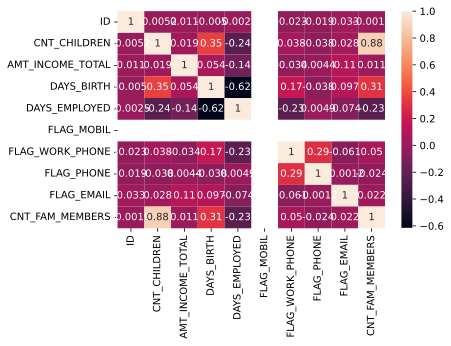

In [ ]:
import seaborn as sn

corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
data.corr()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
ID,1.000000,-0.005178,0.011179,-0.004994,-0.002467,NaN,-0.023319,-0.018992,0.032875,-0.001862
CNT_CHILDREN,-0.005178,1.000000,0.019177,0.349088,-0.241535,NaN,0.038418,-0.038266,0.028457,0.884781
AMT_INCOME_TOTAL,0.011179,0.019177,1.000000,0.053775,-0.141291,NaN,-0.033635,0.004444,0.112139,0.011454
DAYS_BIRTH,-0.004994,0.349088,0.053775,1.000000,-0.617908,NaN,0.171829,-0.037984,0.096752,0.306179
DAYS_EMPLOYED,-0.002467,-0.241535,-0.141291,-0.617908,1.000000,NaN,-0.232208,0.004868,-0.074372,-0.234373
FLAG_MOBIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_WORK_PHONE,-0.023319,0.038418,-0.033635,0.171829,-0.232208,NaN,1.000000,0.290066,-0.060915,0.049777
FLAG_PHONE,-0.018992,-0.038266,0.004444,-0.037984,0.004868,NaN,0.290066,1.000000,-0.001170,-0.024213
FLAG_EMAIL,0.032875,0.028457,0.112139,0.096752,-0.074372,NaN,-0.060915,-0.001170,1.000000,0.022054
CNT_FAM_MEMBERS,-0.001862,0.884781,0.011454,0.306179,-0.234373,NaN,0.049777,-0.024213,0.022054,1.000000


In [ ]:
# Find most important features relative to the earlies_exp
corr = data.corr()
corr.sort_values(["Bad_client"], ascending = False, inplace = True)
print(corr.Bad_client)

In [ ]:
# drop multiple columns

data.drop(["OCCUPATION_TYPE","FLAG_MOBIL",  "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL", "ID" ],axis =1,inplace=True)


In [ ]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))
app = data.copy()

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=app, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=app, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=app, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=app, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=app, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=app, ax=ax[1][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=app, ax=ax[2][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=app, ax=ax[2][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=app, ax=ax[2][2], color= 'orange')

In [ ]:
# FOR CNT_CHILDREN COLUMN
q_hi = app['CNT_CHILDREN'].quantile(0.999)
q_low = app['CNT_CHILDREN'].quantile(0.001)
app = app[(app['CNT_CHILDREN']>q_low) & (app['CNT_CHILDREN']<q_hi)]

In [ ]:
# FOR AMT_INCOME_TOTAL COLUMN
q_hi = app['AMT_INCOME_TOTAL'].quantile(0.999)
q_low = app['AMT_INCOME_TOTAL'].quantile(0.001)
app= app[(app['AMT_INCOME_TOTAL']>q_low) & (app['AMT_INCOME_TOTAL']<q_hi)]

In [ ]:
#FOR CNT_FAM_MEMBERS COLUMN
q_hi = app['CNT_FAM_MEMBERS'].quantile(0.999)
q_low = app['CNT_FAM_MEMBERS'].quantile(0.001)
app= app[(app['CNT_FAM_MEMBERS']>q_low) & (app['CNT_FAM_MEMBERS']<q_hi)]

In [ ]:
# what about skewness?
from scipy.stats import skew
skew(data['AMT_INCOME_TOTAL'])


In [ ]:
# Checking if dataset is balanced 

data_bad_client = data[data.Bad_client == 1]
data_good_client = data[data.Bad_client  == 0]

print(len(data_bad_client))
print(len(data_good_client))

In [ ]:
#balancing the data by using undersampling

# index property contains the indexes of the not_fraud dataset
data_good_client_index = data_good_client.index

# get as many fraud indexes (randomly) as non fraud occurrences
np.random.seed(42)
random_data_good_client_index = np.random.choice(data_good_client_index, len(data_bad_client))

# Keep those entries in not fraud
data_good_client = data.loc[random_data_good_client_index]

# We will form the balanced dataset concatenating fraud and non_fraud
bln = data_bad_client.append(data_good_client)

# Check the result
print(len(bln[bln.Bad_client == 1]))
print(len(bln[bln.Bad_client == 0]))
